**This notebook provide the best practices to consume covid-lake API.**

In [1]:
# General Import

import pandas as pd
import numpy as np
import re
import seaborn as sns

#!pip install scipy
import scipy
pearsonr = scipy.stats.pearsonr

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline

In [1]:
%run /home/ubuntu/notebooks/covid-prj01-data-analysis/[UTILS]/dremio-access-new.py

dremio = DremioQueryMakerJDBC()
index = dremio.getIndex()
index[0:20]
#display(index)

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,VIEW_DEFINITION
0,DREMIO,Covid-Lake,Disease_Indicator,"SELECT createdOn, identifier, valueString, val..."
1,DREMIO,Covid-Lake,hospitalizações,"SELECT * FROM ""hospitalizacoes.csv"""
2,DREMIO,Covid-Lake,Institution,SELECT * FROM logical_entity
3,DREMIO,Covid-Lake,News&Trends,SELECT * FROM logical_entity
4,DREMIO,Covid-Lake,Socioeconomic_Factors,"SELECT createdOn, clean_data_to_FLOAT(valueStr..."
5,DREMIO,covidlake-raw,brasil_io,"SELECT *\nFROM ""brasil.io"""
6,DREMIO,covidlake-raw,cities,"SELECT * FROM ""Base Coordenadas Brasil.parquet"""
7,DREMIO,covidlake-raw,fiocruz_infogripe,SELECT * FROM fiocruz_infogripe
8,DREMIO,covidlake-raw,google_trends,"SELECT * FROM ""google_trends.parquet"""
9,DREMIO,covidlake-raw,health_ministry,SELECT * FROM health_ministry


In [14]:
list(index['TABLE_NAME'])

['Disease_Indicator',
 'hospitalizações',
 'Institution',
 'News&Trends',
 'Socioeconomic_Factors',
 'brasil_io',
 'cities',
 'fiocruz_infogripe',
 'google_trends',
 'health_ministry',
 'hospitals_dimension',
 'mobility_apple',
 'mobility_google',
 'pebmed',
 'wcota',
 'observations',
 'global_dataset',
 'demandas_dos_consumidores_nip',
 'BDCnewsCOVID',
 'treatedBDCcompanies',
 'treatedBDCpeople',
 'cadasto_nacional_de_estabelecimentos_de_saude_cnes',
 'cadasto_nacional_de_estabelecimentos_de_saude_cnes_ativos',
 'cobertura_estimada_da_populacao_residente_pelas_equipes_de_saude_bucal_da_atencao_basica',
 'distribuicao_das_equipes_de_saude_da_familia_esf',
 'distribuicao_de_agentes_comunitarios_de_saude_acs',
 'distribuicao_dos_nucles_de_apoio_a_saude_da_familia_nasf',
 'distribuicao_unidades_basicas_de_saude_em_funcionamento_ubs',
 'distribuicao_unidaes_basicas_de_saude_existentes_ubs',
 'numero_de_equipes_da_saude_da_familia_esf',
 'numero_de_equipes_de_agentes_comunitarios_de_saude_a

In [15]:
health_ministry = dremio.getTable(10)
health_ministry.head()

,UF,HOSPITAL
0,AC,Hospital Geral de Clínicas de Rio Branco
1,AL,HOSPITAL ESCOLA DR. HÉLVIO AUTO
2,AM,Instituto da Criança do Amazonas
3,AM,Instituto da Mulher Dona Lindu
4,AM,Hospital Infantil Dr. Fajardo


In [16]:
health_ministry.shape

(58, 2)

In [8]:
# Rename date column
health_ministry.columns = [
    'index',
    'regiao',
    'estado',
    'data',
    'casosNovos',
    'casosAcumulados',
    'obitosNovos',
    'obitosAcumulados',
    'location_id'
]

NameError: name 'health_ministry' is not defined

In [6]:
health_ministry.head()

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
0,0,Norte,RO,2020-01-30,0,0,0,0,13
1,98,Norte,AC,2020-01-30,0,0,0,0,21
2,196,Norte,AM,2020-01-30,0,0,0,0,4
3,294,Norte,RR,2020-01-30,0,0,0,0,19
4,392,Norte,PA,2020-01-30,0,0,0,0,25


## exploreEntity

Presents an overview of the tables existing in the covid-lake.

URL: http://23.20.157.201/api/exploreEntity

*Each Table represents a CDM (Common Data Model) because it encompesses a set of dataset collected from different sources and mapped following a standard enitity.*

### Let's play with Data :)

- **Analyzing health ministry dataset**

Checking all columns

In [7]:
all_columns = health_ministry.columns.values.tolist()
len(all_columns)
#all_columns

9

In [8]:
all_columns

['index',
 'regiao',
 'estado',
 'data',
 'casosNovos',
 'casosAcumulados',
 'obitosNovos',
 'obitosAcumulados',
 'location_id']

Verifying all NAs

In [9]:
# count NAs per column
#health_ministry.isnull().sum()
health_ministry.isna().sum()

index               0
regiao              0
estado              0
data                0
casosNovos          0
casosAcumulados     0
obitosNovos         0
obitosAcumulados    0
location_id         0
dtype: int64

Dropping all NAs

In [10]:
# shows all NAs
#base_unif.isna()

# remove columns full of NAs
health_ministry = health_ministry.dropna(axis=1,how='all')
health_ministry.head()

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
0,0,Norte,RO,2020-01-30,0,0,0,0,13
1,98,Norte,AC,2020-01-30,0,0,0,0,21
2,196,Norte,AM,2020-01-30,0,0,0,0,4
3,294,Norte,RR,2020-01-30,0,0,0,0,19
4,392,Norte,PA,2020-01-30,0,0,0,0,25


In [11]:
health_ministry.shape

(478261, 9)

Verifying the duplicated columns

In [12]:
# drop duplicates
#base_unif2 = drop_duplicates(base_unif)
health_ministry = health_ministry.drop_duplicates() 
health_ministry.head()
# no duplicates

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
0,0,Norte,RO,2020-01-30,0,0,0,0,13
1,98,Norte,AC,2020-01-30,0,0,0,0,21
2,196,Norte,AM,2020-01-30,0,0,0,0,4
3,294,Norte,RR,2020-01-30,0,0,0,0,19
4,392,Norte,PA,2020-01-30,0,0,0,0,25


In [13]:
health_ministry.shape

(478261, 9)

Shows all the data, though it runs quite slow for big datasets

In [14]:
#force_show_all_columns(base_unif)

Describe the dataset

In [15]:
health_ministry.describe()

,index,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
count,478261.000000,478261.000000,478261.000000,478261.000000,478261.000000,478261.000000
mean,202471.658632,6.170359,170.367086,0.259360,8.651333,14.910720
std,119095.345143,91.150215,2770.693155,4.558447,171.138000,8.200705
min,0.000000,-1812.000000,0.000000,-36.000000,0.000000,1.000000
25%,100349.000000,0.000000,0.000000,0.000000,0.000000,8.000000
50%,201038.000000,0.000000,2.000000,0.000000,0.000000,16.000000
75%,301727.000000,0.000000,15.000000,0.000000,1.000000,21.000000
max,542867.000000,12244.000000,312530.000000,434.000000,15996.000000,27.000000


Describe the fields

In [16]:
list(health_ministry['regiao'].unique())

['Norte', 'Nordeste', 'Sudeste', 'Sul', 'Centro-Oeste']

In [17]:
health_ministry['regiao'].describe()

count       478261
unique           5
top       Nordeste
freq        168610
Name: regiao, dtype: object

Frequency of each state

In [18]:
# array with each count    
counts = np.unique(health_ministry['estado'], return_counts=True)

# dataframe
state_count = pd.DataFrame({'state': counts[0], 'freq': counts[1]})
state_count.sort_values(by=['freq'], inplace=True,ascending=False)
state_count.head()

,state,freq
10,MG,60119
25,SP,58425
4,BA,37316
22,RS,35801
17,PR,30736


Frequency of each region

In [19]:
# array with each count    
counts = np.unique(health_ministry['regiao'], return_counts=True)

# dataframe
region_count = pd.DataFrame({'region': counts[0], 'freq': counts[1]})
region_count.sort_values(by=['freq'], inplace=True,ascending=False)
region_count.head()

,region,freq
1,Nordeste,168610
3,Sudeste,135710
4,Sul,95422
2,Norte,42329
0,Centro-Oeste,36190


Descriptive analysis

In [20]:
health_ministry['casosNovos'].describe()

count    478261.000000
mean          6.170359
std          91.150215
min       -1812.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       12244.000000
Name: casosNovos, dtype: float64

In [21]:
health_ministry['casosAcumulados'].describe()

count    478261.000000
mean        170.367086
std        2770.693155
min           0.000000
25%           0.000000
50%           2.000000
75%          15.000000
max      312530.000000
Name: casosAcumulados, dtype: float64

In [22]:
health_ministry['obitosNovos'].describe()

count    478261.000000
mean          0.259360
std           4.558447
min         -36.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         434.000000
Name: obitosNovos, dtype: float64

In [23]:
health_ministry['obitosAcumulados'].describe()

count    478261.000000
mean          8.651333
std         171.138000
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       15996.000000
Name: obitosAcumulados, dtype: float64

## Graphs

In [24]:
df = health_ministry

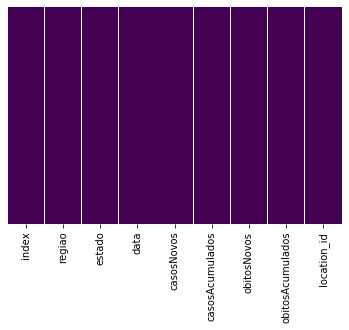

In [25]:
# Missing values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [26]:
# For more details
display(df.isnull().sum().sort_values(ascending=False))

location_id         0
obitosAcumulados    0
obitosNovos         0
casosAcumulados     0
casosNovos          0
data                0
estado              0
regiao              0
index               0
dtype: int64

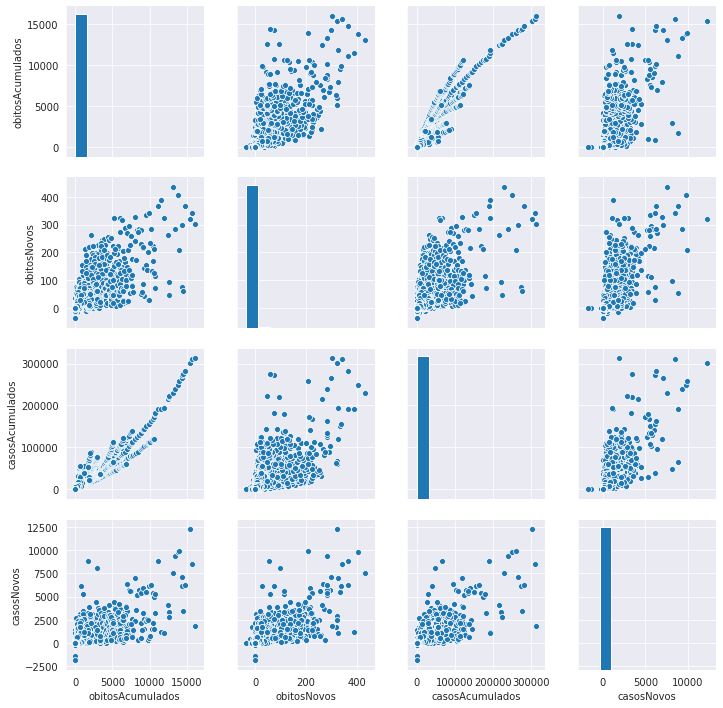

In [27]:
columns = [
    'obitosAcumulados',	 
    'obitosNovos', 
    'casosAcumulados',
    'casosNovos'
    ]
sns.set_style("darkgrid")
sns.pairplot(df[columns])
#sns.pairplot(df[df.columns[-5:]])

### Apparently, the number of accumulated deaths correlates with the number of new deaths, accumulated cases and new cases. Let's verify that:

In [28]:
pearson_cor = pearsonr(df.obitosAcumulados, df.obitosNovos)
print('Pearsons correlation: %.3f' % pearson_cor[0])

Pearsons correlation: 0.806


In [29]:
pearson_cor = pearsonr(df.obitosAcumulados, df.casosAcumulados)
print('Pearsons correlation: %.3f' % pearson_cor[0])

Pearsons correlation: 0.940


In [30]:
pearson_cor = pearsonr(df.obitosAcumulados, df.casosNovos)
print('Pearsons correlation: %.3f' % pearson_cor[0])

Pearsons correlation: 0.761


#### These hypotheses were confirmed, with a very high correlations, above 0.6.

### Unifying the date column to produce more graphs

In [31]:
df.columns

Index(['index', 'regiao', 'estado', 'data', 'casosNovos', 'casosAcumulados',
       'obitosNovos', 'obitosAcumulados', 'location_id'],
      dtype='object')

In [32]:
# Unify the date column format
df['data'] = pd.to_datetime(df.data).dt.date
# Sort dates
df = df.sort_values('data')
cumulated = df.groupby('data').agg({'casosNovos': 'sum',
                                    'obitosNovos': 'sum',
                                    'casosAcumulados': 'sum', 
                                    'obitosAcumulados': 'sum'}).reset_index()

In [33]:
cumulated.head()

,data,casosNovos,obitosNovos,casosAcumulados,obitosAcumulados
0,2020-01-30,0,0,0,0
1,2020-01-31,0,0,0,0
2,2020-02-01,0,0,0,0
3,2020-02-02,0,0,0,0
4,2020-02-03,0,0,0,0


In [34]:
cumulated.describe()

,casosNovos,obitosNovos,casosAcumulados,obitosAcumulados
count,155.000000,155.000000,1.550000e+02,155.000000
mean,19038.980645,800.270968,5.256770e+05,26694.161290
std,25557.610191,920.205668,8.272557e+05,37944.125149
min,0.000000,0.000000,0.000000e+00,0.000000
25%,6.000000,0.000000,2.500000e+01,0.000000
50%,4385.000000,331.000000,6.087400e+04,3857.000000
75%,32757.500000,1499.000000,7.381090e+05,46138.500000
max,96210.000000,2946.000000,3.154008e+06,128530.000000


/home/ubuntu/anaconda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


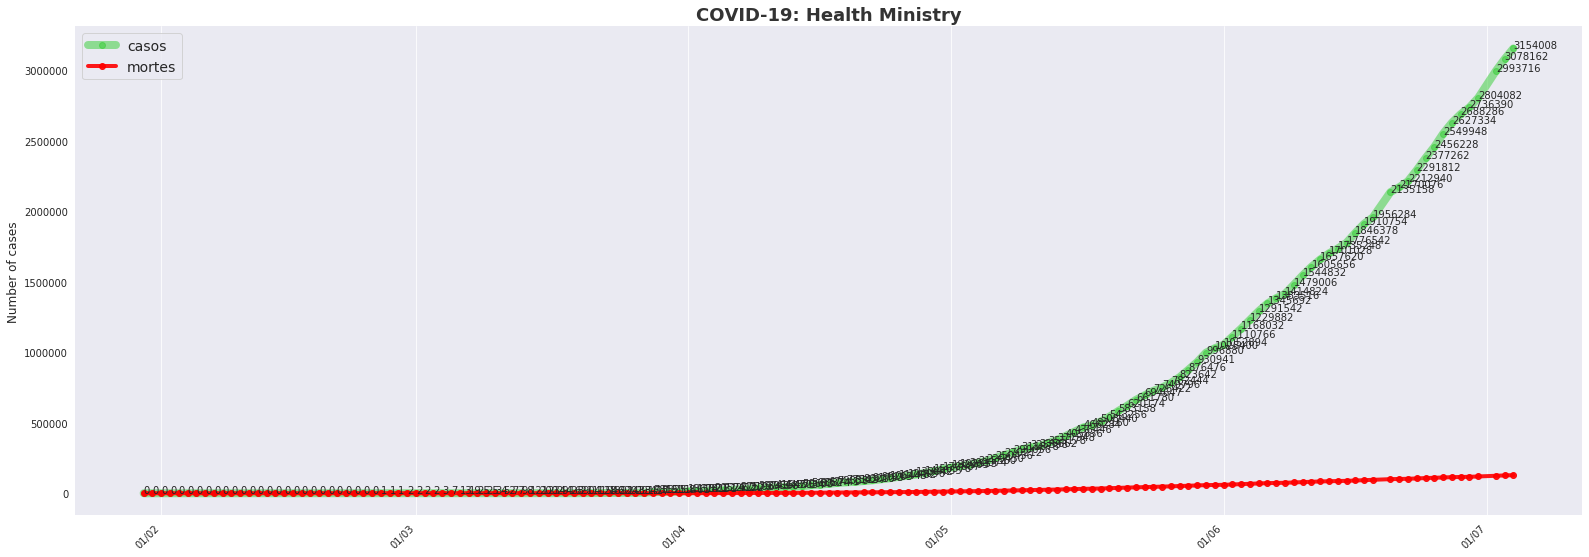

In [35]:
#import matplotlib.pyplot as plt 
#import matplotlib.dates as mdates
#%matplotlib inline

fig, ax = plt.subplots(figsize=(27, 9))

plt.plot(cumulated['data'], cumulated['casosAcumulados'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
plt.plot(cumulated['data'], cumulated['obitosAcumulados'], color='red', linewidth=4, alpha=0.9, marker='o')


[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated['data'], cumulated['casosAcumulados'])]

plt.xticks(rotation=45, ha='right')
plt.title('COVID-19: Health Ministry', fontsize=18, fontweight='bold', color='#333333')

plt.ylabel('Number of cases', fontsize=12)
plt.xlabel(None)

#plt.axvline('2020-03-16', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
#ax.annotate('Companies start home-office', xy=('2020-03-16',19000), fontsize=12, rotation=90)
#plt.axvline('2020-03-21', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
#ax.annotate('SP government declares quarantine', xy=('2020-03-21',19000), fontsize=12, rotation=90)

plt.legend(loc=2, labels=['casos','mortes'], fontsize=14)

plt.grid(which='major', axis='y')
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.show();

#### The number of cases increased while the number of deaths remained basically constant.

In [36]:
np.all(np.diff(cumulated['casosAcumulados']) > 0)

False

In [37]:
np.all(np.diff(cumulated['obitosAcumulados']) > 0)

False

### Confirmed cases distribution

[Text(0.5, 0, '')]

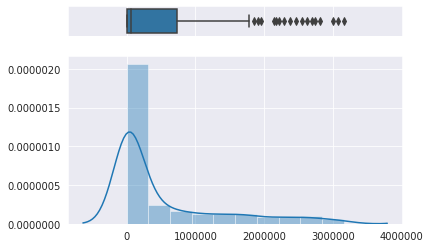

In [38]:
confirmed_cases = cumulated['casosAcumulados'].values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(confirmed_cases, ax=ax_box)
sns.distplot(confirmed_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

### Death cases distribution

[Text(0.5, 0, '')]

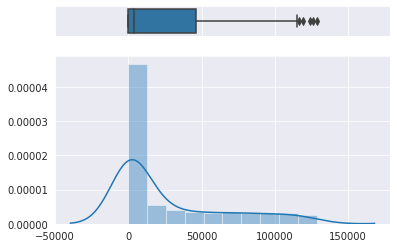

In [39]:
deaths_cases = cumulated['obitosAcumulados'].values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(deaths_cases, ax=ax_box)
sns.distplot(deaths_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [40]:
cumulated.obitosAcumulados.describe()

count       155.000000
mean      26694.161290
std       37944.125149
min           0.000000
25%           0.000000
50%        3857.000000
75%       46138.500000
max      128530.000000
Name: obitosAcumulados, dtype: float64

## But all states are included in the data, as we can see below, so we can plot only SP data, for instance.

In [41]:
df.estado.unique()

array(['RO', 'DF', 'GO', 'MT', 'MS', 'RS', 'SC', 'PR', 'RJ', 'ES', 'MG',
       'BA', 'SE', 'SP', 'PE', 'AL', 'AM', 'RR', 'PA', 'AP', 'TO', 'AC',
       'PI', 'CE', 'RN', 'PB', 'MA'], dtype=object)

In [42]:
df.head()

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
0,0,Norte,RO,2020-01-30,0,0,0,0,13
26,2548,Centro-Oeste,DF,2020-01-30,0,0,0,0,3
25,2450,Centro-Oeste,GO,2020-01-30,0,0,0,0,7
24,2352,Centro-Oeste,MT,2020-01-30,0,0,0,0,12
23,2254,Centro-Oeste,MS,2020-01-30,0,0,0,0,24


In [43]:
df.shape

(478261, 9)

# Analyzing state by state

### Plotting only SP state data

In [44]:
df = health_ministry

In [45]:
df.columns

Index(['index', 'regiao', 'estado', 'data', 'casosNovos', 'casosAcumulados',
       'obitosNovos', 'obitosAcumulados', 'location_id'],
      dtype='object')

In [46]:
# Filtering SP value
SP_boolean = df.estado == 'SP'
SP_boolean

df_sp = df[SP_boolean]
df_sp = df_sp.sort_values('data')
df_sp = df_sp.dropna(subset=['estado'])

df_sp.shape

(58425, 9)

In [47]:
#df.shape

In [48]:
df_sp.head()

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
19,1862,Sudeste,SP,2020-01-30,0,0,0,0,27
46,1863,Sudeste,SP,2020-01-31,0,0,0,0,27
73,1864,Sudeste,SP,2020-02-01,0,0,0,0,27
100,1865,Sudeste,SP,2020-02-02,0,0,0,0,27
127,1866,Sudeste,SP,2020-02-03,0,0,0,0,27


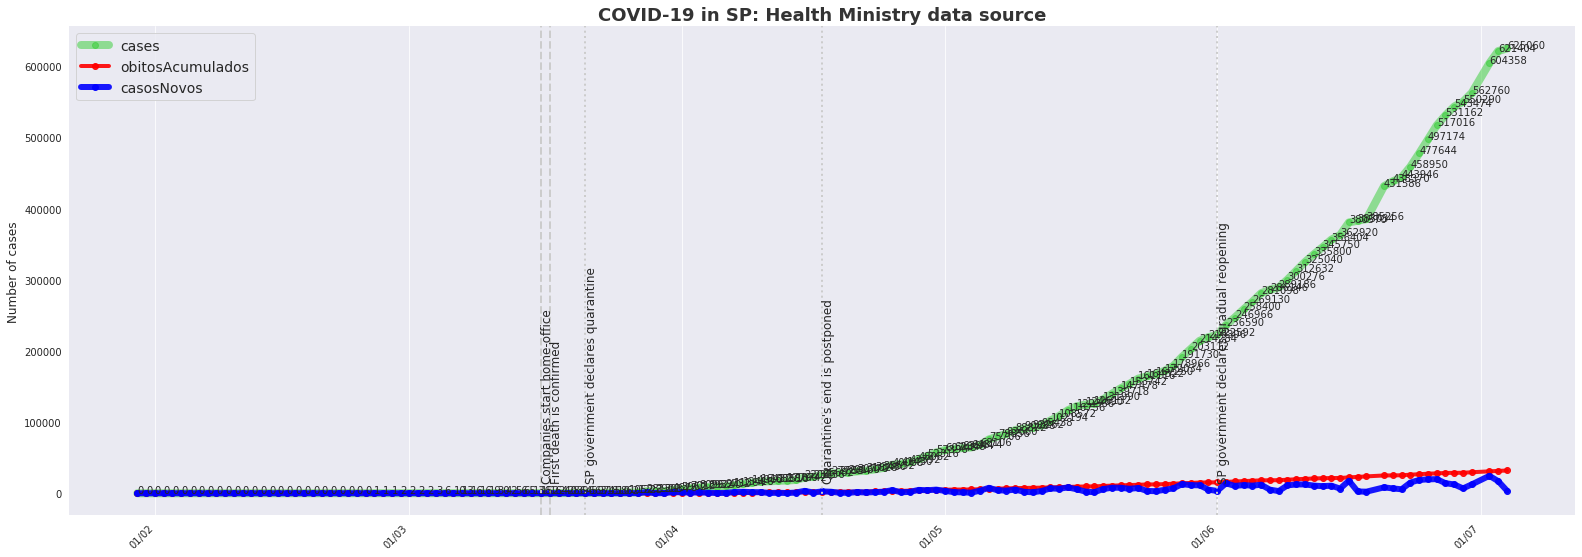

In [49]:
df = health_ministry
estado='SP'
column_sort = 'data'
column_filter = 'estado'
selected_column1 = 'casosAcumulados'
selected_column2 = 'obitosAcumulados'
selected_column3 = 'casosNovos'
title = 'COVID-19 in SP: Health Ministry data source'
label_x = None
label_y = 'Number of cases'
label_legend = 'cases'



df = df.loc[df.estado == estado]

df_shape = df.shape
    
if df_shape[0] == 0:
	print("dataframe with 0 rows")
else:
    if column_sort is not "":
        df = df.sort_values(column_sort)
        
    if column_filter is not "":
            df = df.dropna(subset=[column_filter])
            #df = df.loc[df.place_type == column_filter]     
            cumulated = df.groupby(column_sort).agg({selected_column1: 'sum', selected_column2: 'sum', selected_column3: 'sum'}).reset_index()

            #import matplotlib.pyplot as plt 
            #import matplotlib.dates as mdates
            #%matplotlib inline
            # Plotting

            fig, ax = plt.subplots(figsize=(27, 9))

            plt.plot(cumulated[column_sort], cumulated[selected_column1], color='limegreen', linewidth=8, alpha=0.5, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column2], color='red', linewidth=4, alpha=0.9, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column3], color='blue', linewidth=6, alpha=0.9, marker='o')

            [ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated[column_sort], cumulated[selected_column1])]

            plt.xticks(rotation=45, ha='right')
            plt.title(title, fontsize=18, fontweight='bold', color='#333333')

            plt.ylabel(label_y, fontsize=12)
            plt.xlabel(label_x)

            # Plotting messages

            plt.axvline('2020-03-16', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
            ax.annotate('Companies start home-office', xy=('2020-03-16',19000), fontsize=12, rotation=90)

            plt.axvline('2020-03-17', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
            ax.annotate('First death is confirmed', xy=('2020-03-17',19000), fontsize=12, rotation=90)

            plt.axvline('2020-03-21', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
            ax.annotate('SP government declares quarantine', xy=('2020-03-21',19000), fontsize=12, rotation=90)

            plt.axvline('2020-04-17', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
            ax.annotate("Quarantine's end is postponed", xy=('2020-04-17',19000), fontsize=12, rotation=90)

            plt.axvline('2020-06-01', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
            ax.annotate('SP government declares gradual reopening', xy=('2020-06-01',19000), fontsize=12, rotation=90)

            # Legend and grid

            plt.legend(loc=2, labels=[label_legend,selected_column2, selected_column3], fontsize=14)

            plt.grid(which='major', axis='y')
            [ax.spines[side].set_visible(False) for side in ['left','right','top']]
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            plt.show();

### Plotting only MG state data

In [50]:
df = health_ministry

In [51]:
df.estado.unique()

array(['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
       'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
       'RS', 'MS', 'MT', 'GO', 'DF'], dtype=object)

In [52]:
df.shape

(478261, 9)

In [53]:
# Filtering SP value
MG_boolean = df.estado == 'MG'
MG_boolean

df_mg = df[MG_boolean]

df_mg = df_mg.sort_values('data')
df_mg = df_mg.dropna(subset=['estado'])

df_mg.shape

(60119, 9)

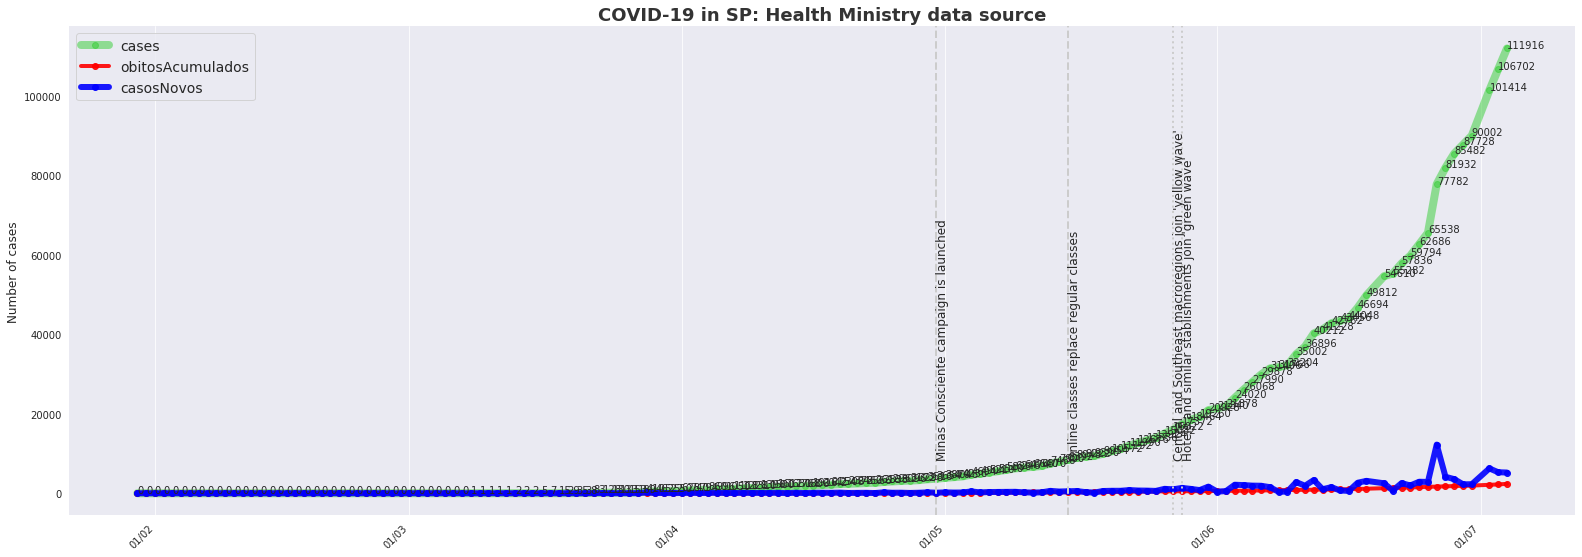

In [54]:
df = health_ministry
estado='MG'
column_sort = 'data'
column_filter = 'estado'
selected_column1 = 'casosAcumulados'
selected_column2 = 'obitosAcumulados'
selected_column3 = 'casosNovos'
title = 'COVID-19 in SP: Health Ministry data source'
label_x = None
label_y = 'Number of cases'
label_legend = 'cases'


# Filtering MG value
df = df.loc[df.estado == estado]

df_shape = df.shape

# if the df is not empty, plot it
if df_shape[0] == 0:
	print("dataframe with 0 rows")
else:
    if column_sort is not "":
        df = df.sort_values(column_sort)
        
    if column_filter is not "":
            df = df.dropna(subset=[column_filter])
            cumulated = df.groupby(column_sort).agg({selected_column1: 'sum', selected_column2: 'sum', selected_column3: 'sum'}).reset_index()

            #import matplotlib.pyplot as plt 
            #import matplotlib.dates as mdates
            #%matplotlib inline
            # Plotting

            fig, ax = plt.subplots(figsize=(27, 9))

            plt.plot(cumulated[column_sort], cumulated[selected_column1], color='limegreen', linewidth=8, alpha=0.5, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column2], color='red', linewidth=4, alpha=0.9, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column3], color='blue', linewidth=6, alpha=0.9, marker='o')

            [ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated[column_sort], cumulated[selected_column1])]

            plt.xticks(rotation=45, ha='right')
            plt.title(title, fontsize=18, fontweight='bold', color='#333333')

            plt.ylabel(label_y, fontsize=12)
            plt.xlabel(label_x)

            # Plotting messages

            plt.axvline('2020-04-30', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
            ax.annotate('Minas Consciente campaign is launched', xy=('2020-04-30',9000), fontsize=12, rotation=90)

            plt.axvline('2020-05-15', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
            ax.annotate('Online classes replace regular classes', xy=('2020-05-15',9000), fontsize=12, rotation=90)

            plt.axvline('2020-05-27', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
            ax.annotate("Central and Southeast macroregions join 'yellow wave'", xy=('2020-05-27',9000), fontsize=12, rotation=90)

            plt.axvline('2020-05-28', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
            ax.annotate("Hotels and similar stablishments join 'green wave'", xy=('2020-05-28',9000), fontsize=12, rotation=90)

            # Legend and grid

            plt.legend(loc=2, labels=[label_legend,selected_column2, selected_column3], fontsize=14)

            plt.grid(which='major', axis='y')
            [ax.spines[side].set_visible(False) for side in ['left','right','top']]
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            plt.show();

#### Comparing the cases in Sao Paulo state (SP) and in Minas Gerais state (MG), in both states the number of cases increased a lot compared to the number of deaths, which remained basically stable. Yet, in SP, the number of new cases presented a peak around July 1st, which can probably be explained by some government decision.

Hypothesis - SP possibly interviened somehow before 01/07, which explains the peak.

### Plotting only Amazonas state data

In [55]:
df = health_ministry

In [56]:
df_am = df.loc[df.estado == 'AM']
df_am.shape

(6056, 9)

In [57]:
df_am.head()

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
2,196,Norte,AM,2020-01-30,0,0,0,0,4
29,197,Norte,AM,2020-01-31,0,0,0,0,4
56,198,Norte,AM,2020-02-01,0,0,0,0,4
83,199,Norte,AM,2020-02-02,0,0,0,0,4
110,200,Norte,AM,2020-02-03,0,0,0,0,4


In [58]:
df_am = df_am.sort_values('data')
df_am = df_am.dropna(subset=['estado'])
cumulated_am = df_am.groupby('data').agg({'casosAcumulados': 'sum', 
                                    'obitosAcumulados': 'sum', 
                                    'casosNovos': 'sum'}).reset_index()

In [59]:
df_am.head()

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
2,196,Norte,AM,2020-01-30,0,0,0,0,4
29,197,Norte,AM,2020-01-31,0,0,0,0,4
56,198,Norte,AM,2020-02-01,0,0,0,0,4
83,199,Norte,AM,2020-02-02,0,0,0,0,4
110,200,Norte,AM,2020-02-03,0,0,0,0,4


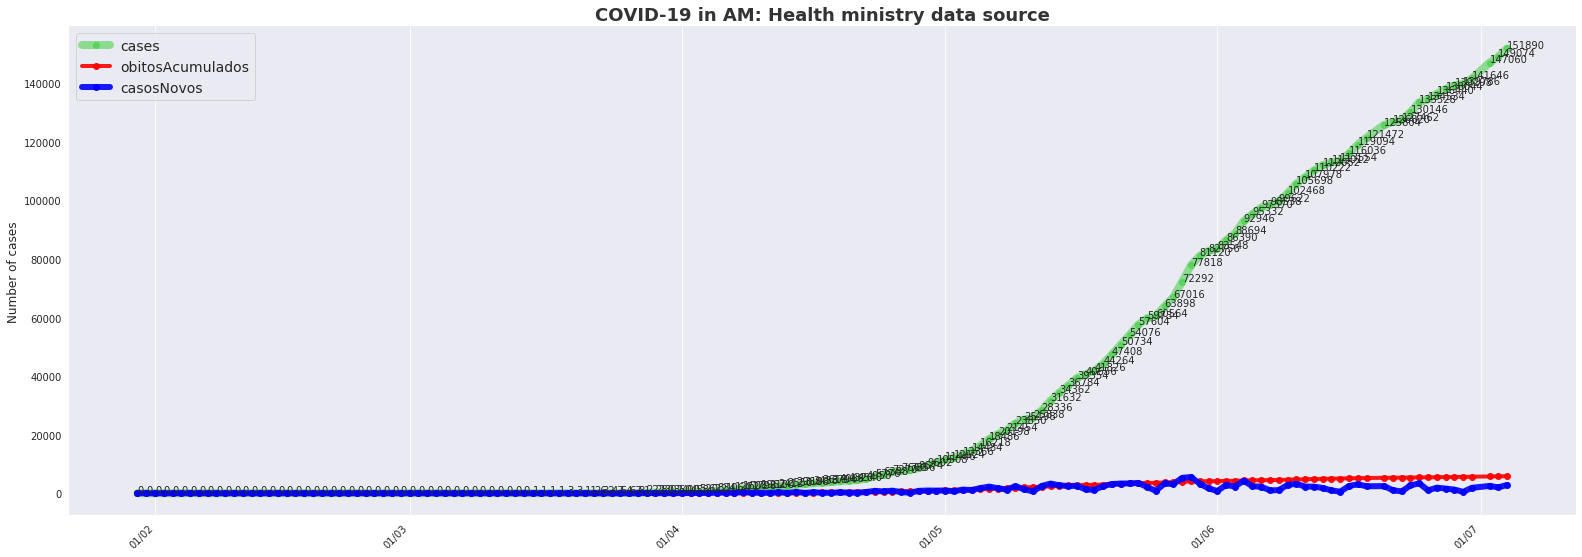

In [60]:
df = health_ministry
estado='AM'
column_sort = 'data'
column_filter = 'estado'
selected_column1 = 'casosAcumulados'
selected_column2 = 'obitosAcumulados'
selected_column3 = 'casosNovos'
title = 'COVID-19 in AM: Health ministry data source'
label_x = None
label_y = 'Number of cases'
label_legend = 'cases'


# Filtering AM value
df = df.loc[df.estado == estado]

df_shape = df.shape
    
if df_shape[0] == 0:
	print("dataframe with 0 rows")
else:
    if column_sort is not "":
        df = df.sort_values(column_sort)
        
    if column_filter is not "":
            df = df.dropna(subset=[column_filter])
            cumulated = df.groupby(column_sort).agg({selected_column1: 'sum', selected_column2: 'sum', selected_column3: 'sum'}).reset_index()

            #import matplotlib.pyplot as plt 
            #import matplotlib.dates as mdates
            #%matplotlib inline
            # Plotting

            fig, ax = plt.subplots(figsize=(27, 9))

            plt.plot(cumulated[column_sort], cumulated[selected_column1], color='limegreen', linewidth=8, alpha=0.5, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column2], color='red', linewidth=4, alpha=0.9, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column3], color='blue', linewidth=6, alpha=0.9, marker='o')

            [ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated[column_sort], cumulated[selected_column1])]

            plt.xticks(rotation=45, ha='right')
            plt.title(title, fontsize=18, fontweight='bold', color='#333333')

            plt.ylabel(label_y, fontsize=12)
            plt.xlabel(label_x)

            
            # Legend and grid

            plt.legend(loc=2, labels=[label_legend,selected_column2, selected_column3], fontsize=14)

            plt.grid(which='major', axis='y')
            [ax.spines[side].set_visible(False) for side in ['left','right','top']]
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            plt.show();

#### In the Amazonas state, the number of confirmed deaths is rising with the number of cases.

### Plotting only RS state data

In [61]:
df = health_ministry

In [62]:
df_rs = df.loc[df.estado == 'RS']
df_rs.shape

(35801, 9)

In [63]:
df_rs.head()

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
22,2156,Sul,RS,2020-01-30,0,0,0,0,20
49,2157,Sul,RS,2020-01-31,0,0,0,0,20
76,2158,Sul,RS,2020-02-01,0,0,0,0,20
103,2159,Sul,RS,2020-02-02,0,0,0,0,20
130,2160,Sul,RS,2020-02-03,0,0,0,0,20


In [64]:
df_rs = df_rs.sort_values('data')
df_rs = df_rs.dropna(subset=['estado'])
cumulated_rs = df_rs.groupby('data').agg({'casosAcumulados': 'sum', 
                                    'obitosAcumulados': 'sum', 
                                    'casosNovos': 'sum'}).reset_index()

In [65]:
df_rs.head()

,index,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados,location_id
22,2156,Sul,RS,2020-01-30,0,0,0,0,20
49,2157,Sul,RS,2020-01-31,0,0,0,0,20
76,2158,Sul,RS,2020-02-01,0,0,0,0,20
103,2159,Sul,RS,2020-02-02,0,0,0,0,20
130,2160,Sul,RS,2020-02-03,0,0,0,0,20


In [66]:
cumulated_rs.head()

,data,casosAcumulados,obitosAcumulados,casosNovos
0,2020-01-30,0,0,0
1,2020-01-31,0,0,0
2,2020-02-01,0,0,0
3,2020-02-02,0,0,0
4,2020-02-03,0,0,0


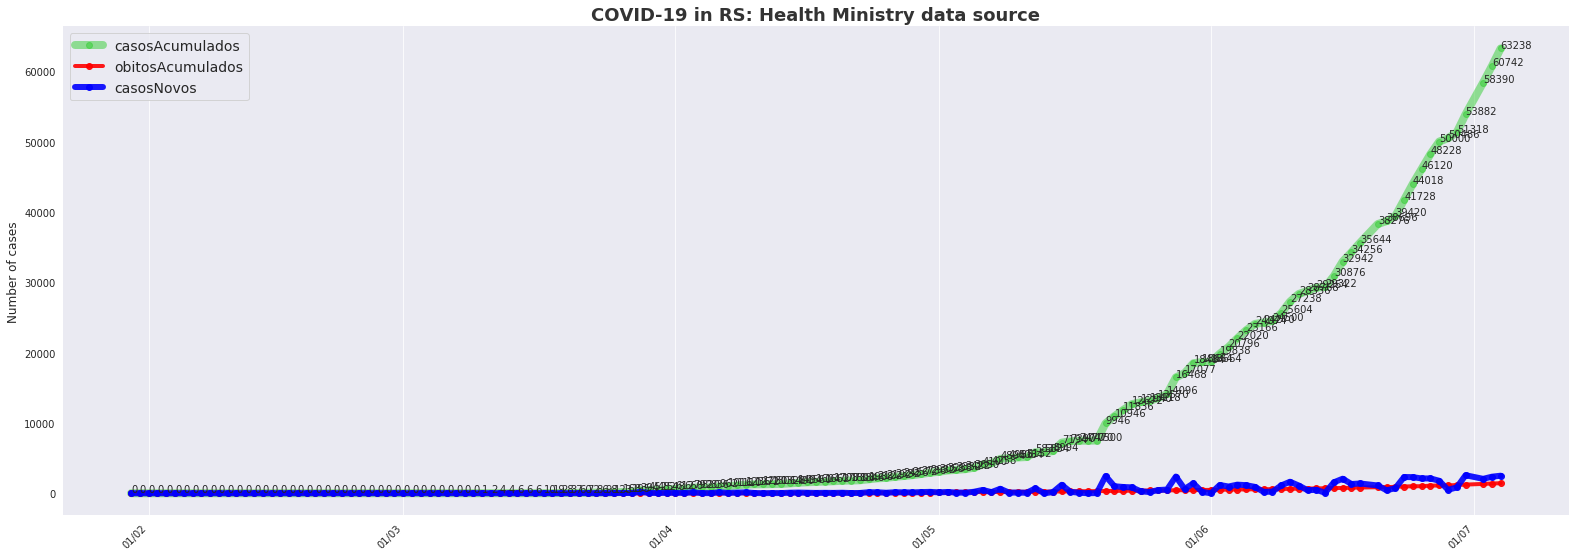

In [67]:
#import matplotlib.pyplot as plt 
#import matplotlib.dates as mdates
#%matplotlib inline

fig, ax = plt.subplots(figsize=(27, 9))

plt.plot(cumulated_rs['data'], cumulated_rs['casosAcumulados'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
plt.plot(cumulated_rs['data'], cumulated_rs['obitosAcumulados'], color='red', linewidth=4, alpha=0.9, marker='o')
plt.plot(cumulated_rs['data'], cumulated_rs['casosNovos'], color='blue', linewidth=6, alpha=0.9, marker='o')


[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated_rs['data'], cumulated_rs['casosAcumulados'])]

plt.xticks(rotation=45, ha='right')
plt.title('COVID-19 in RS: Health Ministry data source', fontsize=18, fontweight='bold', color='#333333')

plt.ylabel('Number of cases', fontsize=12)
plt.xlabel(None)

#plt.axvline('2020-03-16', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
#ax.annotate('Companies start home-office', xy=('2020-03-16',19000), fontsize=12, rotation=90)
#plt.axvline('2020-03-17', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
#ax.annotate('First death is confirmed', xy=('2020-03-17',19000), fontsize=12, rotation=90)
#plt.axvline('2020-03-21', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
#ax.annotate('SP government declares quarantine', xy=('2020-03-21',19000), fontsize=12, rotation=90)
#plt.axvline('2020-04-17', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
#ax.annotate("Quarantine's end is postponed", xy=('2020-04-17',19000), fontsize=12, rotation=90)
#plt.axvline('2020-06-01', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
#ax.annotate('SP government declares gradual reopening', xy=('2020-06-01',19000), fontsize=12, rotation=90)

plt.legend(loc=2, labels=['casosAcumulados','obitosAcumulados', 'casosNovos'], fontsize=14)

plt.grid(which='major', axis='y')
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.show();

### Plotting only Espirito Santo state data

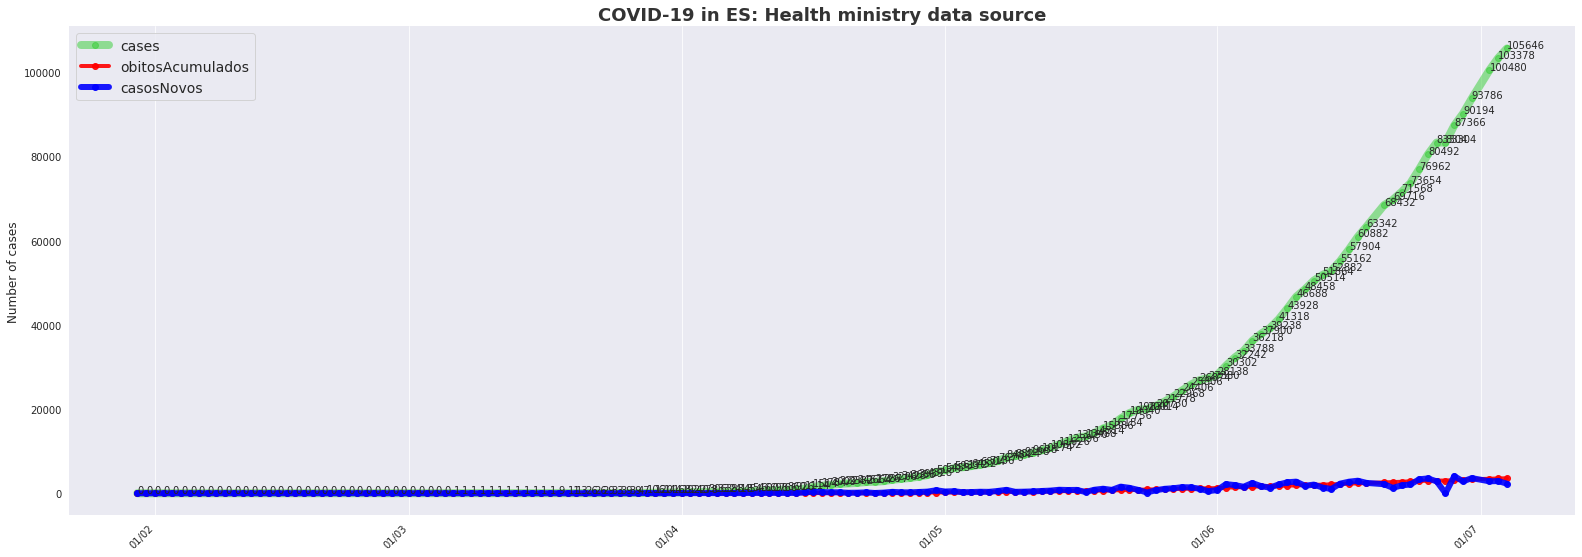

In [68]:
df = health_ministry
estado='ES'
column_sort = 'data'
column_filter = 'estado'
selected_column1 = 'casosAcumulados'
selected_column2 = 'obitosAcumulados'
selected_column3 = 'casosNovos'
title = 'COVID-19 in ES: Health ministry data source'
label_x = None
label_y = 'Number of cases'
label_legend = 'cases'

# Filtering ES value
df = df.loc[df.estado == estado]

df_shape = df.shape
    
if df_shape[0] == 0:
	print("dataframe with 0 rows")
else:
    if column_sort is not "":
        df = df.sort_values(column_sort)
        
    if column_filter is not "":
            df = df.dropna(subset=[column_filter])
            cumulated = df.groupby(column_sort).agg({selected_column1: 'sum', selected_column2: 'sum', selected_column3: 'sum'}).reset_index()

            #import matplotlib.pyplot as plt 
            #import matplotlib.dates as mdates
            #%matplotlib inline
            # Plotting

            fig, ax = plt.subplots(figsize=(27, 9))

            plt.plot(cumulated[column_sort], cumulated[selected_column1], color='limegreen', linewidth=8, alpha=0.5, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column2], color='red', linewidth=4, alpha=0.9, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column3], color='blue', linewidth=6, alpha=0.9, marker='o')

            [ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated[column_sort], cumulated[selected_column1])]

            plt.xticks(rotation=45, ha='right')
            plt.title(title, fontsize=18, fontweight='bold', color='#333333')

            plt.ylabel(label_y, fontsize=12)
            plt.xlabel(label_x)

            
            # Legend and grid

            plt.legend(loc=2, labels=[label_legend,selected_column2, selected_column3], fontsize=14)

            plt.grid(which='major', axis='y')
            [ax.spines[side].set_visible(False) for side in ['left','right','top']]
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            plt.show();

### In this case, the increase in the cases was followed closely by an increase of the number of deaths.

# In some states, though, there was a decrease at some point, which explains the peaks in the general graph

### Acre

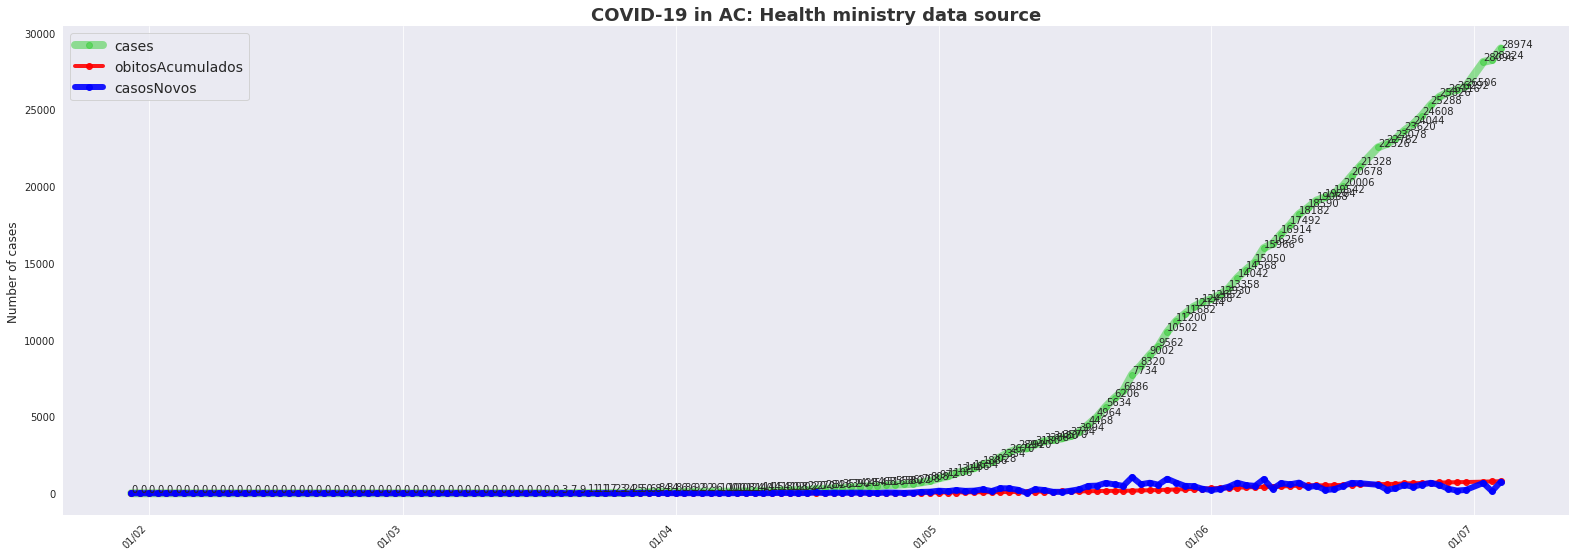

In [69]:
df = health_ministry
estado='AC'
column_sort = 'data'
column_filter = 'estado'
selected_column1 = 'casosAcumulados'
selected_column2 = 'obitosAcumulados'
selected_column3 = 'casosNovos'
title = 'COVID-19 in AC: Health ministry data source'
label_x = None
label_y = 'Number of cases'
label_legend = 'cases'

# Filtering AC value
df = df.loc[df.estado == estado]

df_shape = df.shape
    
if df_shape[0] == 0:
	print("dataframe with 0 rows")
else:
    if column_sort is not "":
        df = df.sort_values(column_sort)
        
    if column_filter is not "":
            df = df.dropna(subset=[column_filter])
            cumulated = df.groupby(column_sort).agg({selected_column1: 'sum', selected_column2: 'sum', selected_column3: 'sum'}).reset_index()

            #import matplotlib.pyplot as plt 
            #import matplotlib.dates as mdates
            #%matplotlib inline
            # Plotting

            fig, ax = plt.subplots(figsize=(27, 9))

            plt.plot(cumulated[column_sort], cumulated[selected_column1], color='limegreen', linewidth=8, alpha=0.5, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column2], color='red', linewidth=4, alpha=0.9, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column3], color='blue', linewidth=6, alpha=0.9, marker='o')

            [ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated[column_sort], cumulated[selected_column1])]

            plt.xticks(rotation=45, ha='right')
            plt.title(title, fontsize=18, fontweight='bold', color='#333333')

            plt.ylabel(label_y, fontsize=12)
            plt.xlabel(label_x)

            
            # Legend and grid

            plt.legend(loc=2, labels=[label_legend,selected_column2, selected_column3], fontsize=14)

            plt.grid(which='major', axis='y')
            [ax.spines[side].set_visible(False) for side in ['left','right','top']]
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            plt.show();

### Roraima

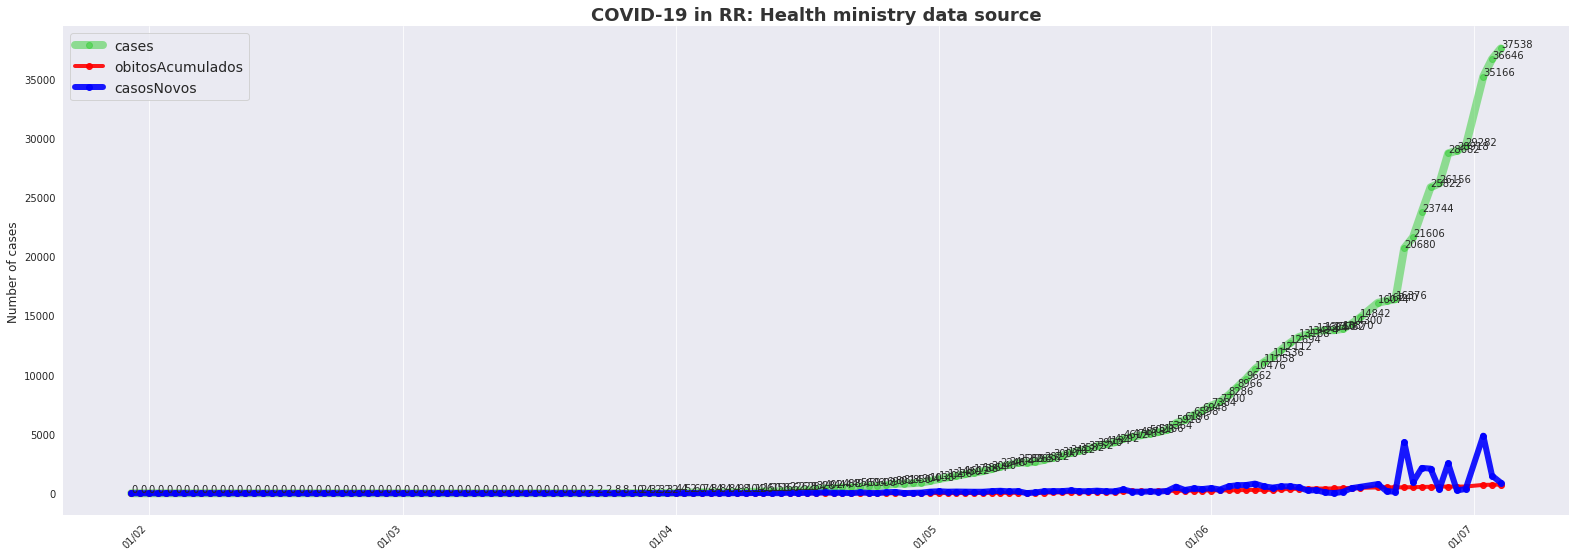

In [70]:
df = health_ministry
estado='RR'
column_sort = 'data'
column_filter = 'estado'
selected_column1 = 'casosAcumulados'
selected_column2 = 'obitosAcumulados'
selected_column3 = 'casosNovos'
title = 'COVID-19 in RR: Health ministry data source'
label_x = None
label_y = 'Number of cases'
label_legend = 'cases'

# Filtering RR value
df = df.loc[df.estado == estado]

df_shape = df.shape
    
if df_shape[0] == 0:
	print("dataframe with 0 rows")
else:
    if column_sort is not "":
        df = df.sort_values(column_sort)
        
    if column_filter is not "":
            df = df.dropna(subset=[column_filter])
            cumulated = df.groupby(column_sort).agg({selected_column1: 'sum', selected_column2: 'sum', selected_column3: 'sum'}).reset_index()

            #import matplotlib.pyplot as plt 
            #import matplotlib.dates as mdates
            #%matplotlib inline
            # Plotting

            fig, ax = plt.subplots(figsize=(27, 9))

            plt.plot(cumulated[column_sort], cumulated[selected_column1], color='limegreen', linewidth=8, alpha=0.5, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column2], color='red', linewidth=4, alpha=0.9, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column3], color='blue', linewidth=6, alpha=0.9, marker='o')

            [ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated[column_sort], cumulated[selected_column1])]

            plt.xticks(rotation=45, ha='right')
            plt.title(title, fontsize=18, fontweight='bold', color='#333333')

            plt.ylabel(label_y, fontsize=12)
            plt.xlabel(label_x)

            
            # Legend and grid

            plt.legend(loc=2, labels=[label_legend,selected_column2, selected_column3], fontsize=14)

            plt.grid(which='major', axis='y')
            [ax.spines[side].set_visible(False) for side in ['left','right','top']]
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            plt.show();

### Mato Grosso do Sul

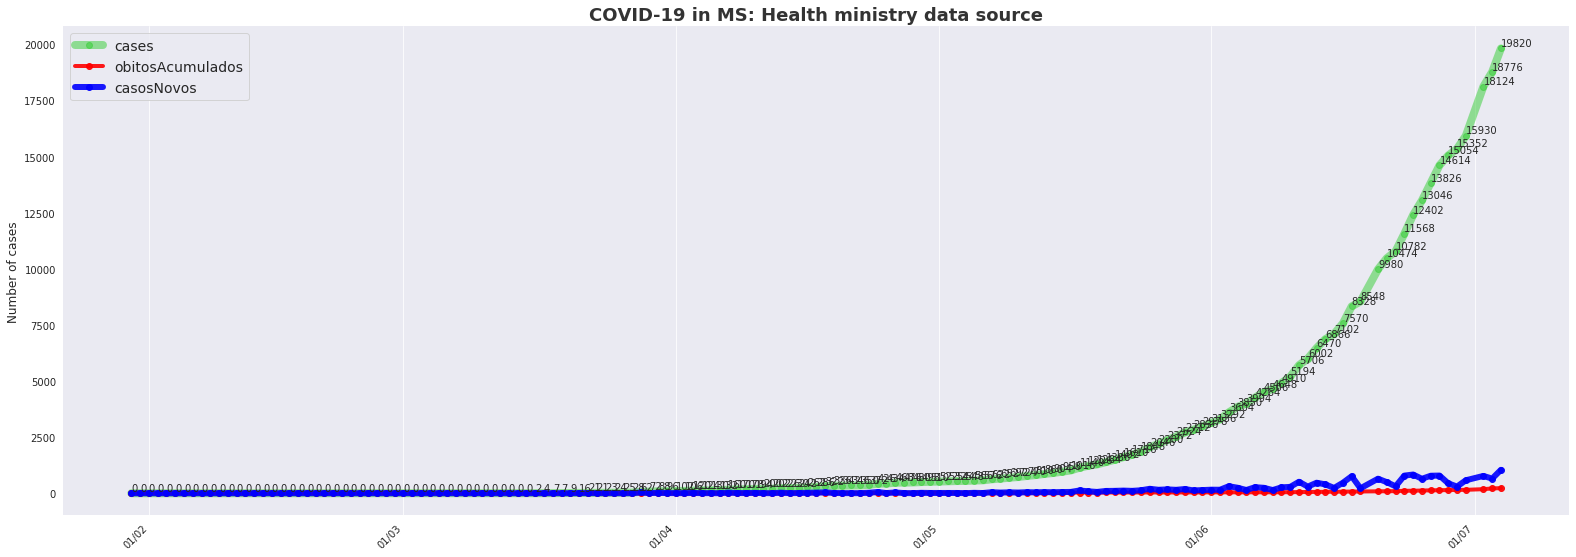

In [71]:
df = health_ministry
estado='MS'
column_sort = 'data'
column_filter = 'estado'
selected_column1 = 'casosAcumulados'
selected_column2 = 'obitosAcumulados'
selected_column3 = 'casosNovos'
title = 'COVID-19 in MS: Health ministry data source'
label_x = None
label_y = 'Number of cases'
label_legend = 'cases'

# Filtering MS value
df = df.loc[df.estado == estado]

df_shape = df.shape
    
if df_shape[0] == 0:
	print("dataframe with 0 rows")
else:
    if column_sort is not "":
        df = df.sort_values(column_sort)
        
    if column_filter is not "":
            df = df.dropna(subset=[column_filter])
            cumulated = df.groupby(column_sort).agg({selected_column1: 'sum', selected_column2: 'sum', selected_column3: 'sum'}).reset_index()

            #import matplotlib.pyplot as plt 
            #import matplotlib.dates as mdates
            #%matplotlib inline
            # Plotting

            fig, ax = plt.subplots(figsize=(27, 9))

            plt.plot(cumulated[column_sort], cumulated[selected_column1], color='limegreen', linewidth=8, alpha=0.5, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column2], color='red', linewidth=4, alpha=0.9, marker='o')
            plt.plot(cumulated[column_sort], cumulated[selected_column3], color='blue', linewidth=6, alpha=0.9, marker='o')

            [ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated[column_sort], cumulated[selected_column1])]

            plt.xticks(rotation=45, ha='right')
            plt.title(title, fontsize=18, fontweight='bold', color='#333333')

            plt.ylabel(label_y, fontsize=12)
            plt.xlabel(label_x)

            
            # Legend and grid

            plt.legend(loc=2, labels=[label_legend,selected_column2, selected_column3], fontsize=14)

            plt.grid(which='major', axis='y')
            [ax.spines[side].set_visible(False) for side in ['left','right','top']]
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            plt.show();

#### In the RR state, different to other states, there are several low peaks around 01/07. The only state similar is SP, although in SP there was only one peak.

### Conclusion

#### As a conclusion, the general behavior was erratic due to the influence of different states' data. So, further studies are necessary using, preferably, modelling or machine learning to describe the main features as soon as new information is released.

## *Developed by*

 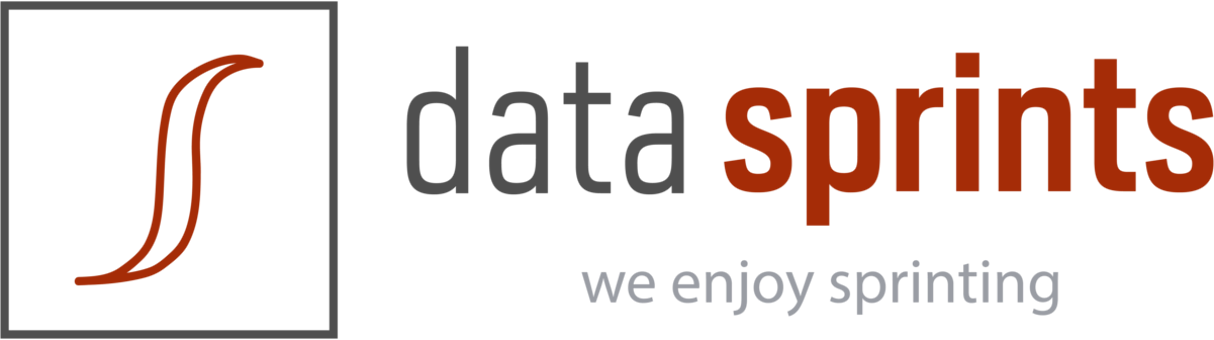